# 安装配置环境



In [ ]:
!pip install numpy pandas matplotlib seaborn plotly requests tqdm opencv-python pillow wandb -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 527.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 299.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 178.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 102.7 kB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=97150f204c6d3f4e68520aaf91d2f419d2927e70c3677a7a3e00d8737f513e5f
  Stored in directory: /root/.cache/pip/wheels/b7/31/e6/19ca1592f9946bc5e44fddcb324e639092a939c6ef197b71e5
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urll

## 下载安装Pytorch

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113


## 创建目录

In [ ]:
import os

In [ ]:
# 存放结果文件
os.mkdir('output')

# 存放训练得到的模型权重
os.mkdir('checkpoints')

# 存放生成的图表
os.mkdir('图表')

## 构建数据集

In [ ]:
# 下载数据集压缩包
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip

--2023-01-10 12:05:08--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226278151 (216M) [application/zip]
Saving to: ‘fruit30_split.zip’

fruit30_split.zip   100%[===================>] 215.79M  35.1MB/s    in 6.3s    

2023-01-10 12:05:15 (34.5 MB/s) - ‘fruit30_split.zip’ saved [226278151/226278151]



In [ ]:
# 解压
!unzip fruit30_split.zip >> /dev/null

# 删除压缩包
!rm fruit30_split.zip

# 基于迁移学习微调训练的基础版图像分类模型



In [ ]:
import time
import os

import numpy as np
from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [ ]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
# 数据集文件夹路径
dataset_dir = 'fruit30_split'


train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
print('训练集路径', train_path)
print('测试集路径', test_path)

训练集路径 fruit30_split/train
测试集路径 fruit30_split/val


In [ ]:
from torchvision import datasets

# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)

# root：图片存储的根目录。
# transform：对图片进行预处理的操作（函数），原始图片作为输入，返回一个转换后的图片。

# 载入测试集
test_dataset = datasets.ImageFolder(test_path, test_transform)

# 查看训练集
print('训练集图像数量', len(train_dataset))
print('类别个数', len(train_dataset.classes))
print('各类别名称', train_dataset.classes)


# 查看测试集
print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

训练集图像数量 4375
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']
测试集图像数量 1078
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


In [ ]:
class_names = train_dataset.classes
n_class = len(class_names)


class_names # 显示类别

['哈密瓜',
 '圣女果',
 '山竹',
 '杨梅',
 '柚子',
 '柠檬',
 '桂圆',
 '梨',
 '椰子',
 '榴莲',
 '火龙果',
 '猕猴桃',
 '石榴',
 '砂糖橘',
 '胡萝卜',
 '脐橙',
 '芒果',
 '苦瓜',
 '苹果-红',
 '苹果-青',
 '草莓',
 '荔枝',
 '菠萝',
 '葡萄-白',
 '葡萄-红',
 '西瓜',
 '西红柿',
 '车厘子',
 '香蕉',
 '黄瓜']

In [ ]:
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}


idx_to_labels

{0: '哈密瓜',
 1: '圣女果',
 2: '山竹',
 3: '杨梅',
 4: '柚子',
 5: '柠檬',
 6: '桂圆',
 7: '梨',
 8: '椰子',
 9: '榴莲',
 10: '火龙果',
 11: '猕猴桃',
 12: '石榴',
 13: '砂糖橘',
 14: '胡萝卜',
 15: '脐橙',
 16: '芒果',
 17: '苦瓜',
 18: '苹果-红',
 19: '苹果-青',
 20: '草莓',
 21: '荔枝',
 22: '菠萝',
 23: '葡萄-白',
 24: '葡萄-红',
 25: '西瓜',
 26: '西红柿',
 27: '车厘子',
 28: '香蕉',
 29: '黄瓜'}

In [ ]:
# 保存为本地的 npy 文件
np.save('idx_to_labels.npy', idx_to_labels)
np.save('labels_to_idx.npy', train_dataset.class_to_idx)

In [ ]:
# 定义数据加载器DataLoader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True, # 随机打乱顺序
                          num_workers=4 # 设置CPU线程
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

In [ ]:
# 查看一个batch的图像及其标签
# DataLoader 是 python生成器，每次调用返回一个 batch 的数据
images, labels = next(iter(train_loader)) # next()往往与iter()联合使用，next()表示迭代，iter()中为迭代对象，整体作为迭代器逐个遍历train_loader

In [ ]:
images.shape

torch.Size([32, 3, 224, 224])

In [ ]:
labels

tensor([21,  4,  5,  9, 27, 11,  5,  6, 24, 29,  0, 12, 27, 18,  2, 25, 18,  0,
        20,  5,  1, 20,  8, 29, 25, 18, 14, 17, 11, 10, 26, 13])

In [ ]:
# 查看一个图像及其标签
# 将数据集中的Tensor张量转为numpy的array数据类型
images = images.numpy()

In [ ]:
images[2].shape

(3, 224, 224)

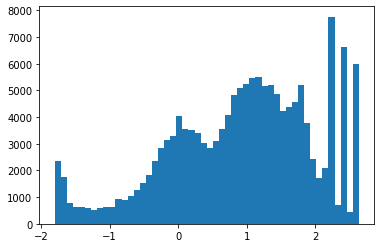

In [ ]:
plt.hist(images[5].flatten(), bins=50) # 绘制柱状图，将images[2]拉伸为一维数组，然后绘制总共50个柱体，此处注意每个像素都被归一化
plt.show()

Text(0.5, 1.0, 'label:5')

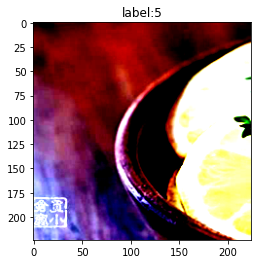

In [ ]:
# 经过预处理的图像
idx = 2
plt.imshow(images[idx].transpose((1,2,0))) # 此处通道数要放在后面，转为(224, 224, 3)，原因是matplotlib库的要求
plt.title('label:'+str(labels[idx].item()))

In [ ]:
label = labels[idx].item()
pred_classname = idx_to_labels[label]

In [ ]:
pred_classname

'柠檬'

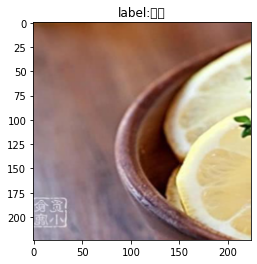

In [ ]:
# 展示像素归一化前的原始图像
idx = 2
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(np.clip(images[idx].transpose((1,2,0)) * std + mean, 0, 1))
plt.title('label:'+ pred_classname)
plt.show()

In [ ]:
# 开始训练！
# 以一个batch为例进行训练

from torchvision import models
import torch.optim as optim

In [ ]:
# 设置迁移学习的三种方式

# 选择一：只微调训练模型最后一层（全连接分类层）
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model.fc

Linear(in_features=512, out_features=30, bias=True)

In [ ]:
# 只微调训练最后一层全连接层的参数，其它层不处理
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
# 选择二：微调训练所有层
# model = models.resnet18(pretrained=True) # 载入预训练模型

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())


In [ ]:
# 选择三：随机初始化模型全部权重，从头训练所有层
# model = models.resnet18(pretrained=False) # 只载入模型结构，不载入预训练权重参数

# model.fc = nn.Linear(model.fc.in_features, n_class)

# optimizer = optim.Adam(model.parameters())

In [ ]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 20

In [ ]:
# 获得一个 batch 的数据和标注

images, labels = next(iter(train_loader))
images = images.to(device)
labels = labels.to(device)

In [ ]:
# 输入模型，执行前向预测
outputs = model(images)

In [ ]:
# 获得当前 batch 所有图像的预测类别 logit 分数
outputs.shape

torch.Size([32, 30])

In [ ]:
# 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
loss = criterion(outputs, labels)
optimizer.zero_grad() # 清除梯度
loss.backward() # 反向传播
optimizer.step() # 优化更新

In [ ]:
# 获得当前 batch 所有图像的预测类别
_, preds = torch.max(outputs, 1)

# 其实下划线相当于一个变量，比如定义变量a，然后后面又有一个变量preds，所以中间当然要加逗号
# 不加下划线表示返回一行中最大的数，加下划线表示返回一行中最大数的索引。

In [ ]:
preds # 显示预测类别

tensor([17, 10, 17, 24, 23, 21, 23, 23, 24,  4, 17, 23, 17, 21, 23, 23, 24, 12,
        17,  4, 10, 17,  2, 17, 12, 16, 24,  2, 23, 17, 21, 17],
       device='cuda:0')

In [ ]:
labels # 显示真正类别

tensor([16, 21, 16, 18,  1, 11, 17,  3, 28,  8, 22, 25, 16, 23, 19, 27, 24, 15,
         3, 24,  0, 28, 25, 16, 15, 28, 27, 22, 19, 12, 22, 21],
       device='cuda:0')

In [ ]:
# 运行完整训练

# 遍历每个epoch，每一个epoch遍历所有batch
for epoch in tqdm(range(EPOCHS)):

    model.train()

    for images, labels in train_loader:  # 遍历每一个batch，在内层循环的一次循环中获得一个batch的数据和标注
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) # 计算当前batch中，每个样本的平均交叉熵损失函数值
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 20/20 [08:19<00:00, 24.97s/it]


In [ ]:
# 进行测试！

model.eval() # 使model转为evaluation模式
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum()

    print('测试集上的准确率为 {:.3f} %'.format(100 * correct / total))

100%|██████████| 34/34 [00:07<00:00,  4.83it/s]

测试集上的准确率为 87.291 %


In [ ]:
# 保存模型的参数
torch.save(model, 'checkpoints/fruit30_pytorch_20220814.pth')

## 优化后的图像分类模型 ##

In [ ]:
import time # 可以获取当前的年-月-日-时间
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 获取计算硬件
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [ ]:
from torchvision import transforms

# 训练集图像预处理：缩放裁剪、图像增强、转 Tensor、归一化
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
# 设置数据集文件夹路径
dataset_dir = 'fruit30_split'
train_path = os.path.join(dataset_dir, 'train')
test_path = os.path.join(dataset_dir, 'val')
from torchvision import datasets
# 载入训练集
train_dataset = datasets.ImageFolder(train_path, train_transform)
# 载入测试集时
test_dataset = datasets.ImageFolder(test_path, test_transform)

In [ ]:
# 各类别名称
class_names = train_dataset.classes
n_class = len(class_names)
# 映射关系：类别 到 索引号
train_dataset.class_to_idx
# 映射关系：索引号 到 类别
idx_to_labels = {y:x for x,y in train_dataset.class_to_idx.items()}

In [ ]:
from torch.utils.data import DataLoader # DataLoader 是 python生成器，每次调用返回一个 batch 的数据

BATCH_SIZE = 32

# 训练集的数据加载器
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4
                         )

# 测试集的数据加载器
test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4
                        )

In [ ]:
# 导入训练所需要的包
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
# 此处选择
model = models.resnet18(pretrained=True) # 载入预训练模型

# 修改全连接层，使得全连接层的输出与当前数据集类别数对应
# 新建的层默认 requires_grad=True
model.fc = nn.Linear(model.fc.in_features, n_class)
# 只微调训练最后一层全连接层的参数，其它层冻结
optimizer = optim.Adam(model.fc.parameters())

In [ ]:
model = model.to(device)

# 交叉熵损失函数
criterion = nn.CrossEntropyLoss() 

# 训练轮次 Epoch
EPOCHS = 30

# 学习率降低策略
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # 采用阶梯变化的学习率

In [ ]:
# 选取评估指标

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
# 用于在训练中的函数
def train_one_batch(images, labels):
    '''
    运行一个 batch 的训练，返回当前 batch 的训练日志
    '''
    
    # 获得一个 batch 的数据和标注
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model(images) # 输入模型，执行前向预测
    loss = criterion(outputs, labels) # 计算当前 batch 中，每个样本的平均交叉熵损失函数值
    
    # 优化更新权重
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 获取当前 batch 的标签类别和预测类别
    _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
    preds = preds.cpu().numpy()
    loss = loss.detach().cpu().numpy()
    outputs = outputs.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()
    
    log_train = {}
    log_train['epoch'] = epoch
    log_train['batch'] = batch_idx
    # 计算分类评估指标
    log_train['train_loss'] = loss
    log_train['train_accuracy'] = accuracy_score(labels, preds)
    # log_train['train_precision'] = precision_score(labels, preds, average='macro')
    # log_train['train_recall'] = recall_score(labels, preds, average='macro')
    # log_train['train_f1-score'] = f1_score(labels, preds, average='macro')
    
    return log_train

In [ ]:
# 用于在测试中的函数
def evaluate_testset():
    '''
    在整个测试集上评估，返回分类评估指标日志
    '''

    loss_list = []
    labels_list = []
    preds_list = []
    
    with torch.no_grad():
        for images, labels in test_loader: # 生成一个 batch 的数据和标注
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) # 输入模型，执行前向预测

            # 获取整个测试集的标签类别和预测类别
            _, preds = torch.max(outputs, 1) # 获得当前 batch 所有图像的预测类别
            preds = preds.cpu().numpy()
            loss = criterion(outputs, labels) # 由 logit，计算当前 batch 中，每个样本的平均交叉熵损失函数值
            loss = loss.detach().cpu().numpy()
            outputs = outputs.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()

            loss_list.append(loss)
            labels_list.extend(labels)
            preds_list.extend(preds)
        
    log_test = {}
    log_test['epoch'] = epoch
    
    # 计算分类评估指标
    log_test['test_loss'] = np.mean(loss)
    # 注意accuracy（准确率）不等于precision（精确度）
    log_test['test_accuracy'] = accuracy_score(labels_list, preds_list)
    # 分析的对象不相同
    log_test['test_precision'] = precision_score(labels_list, preds_list, average='macro') # 挑出的西瓜中有多少是好瓜
    log_test['test_recall'] = recall_score(labels_list, preds_list, average='macro') # 即查全率，所有好瓜中有多少被挑出来

    log_test['test_f1-score'] = f1_score(labels_list, preds_list, average='macro') # F1值的一般形式为查准率和查全率的调和均值,F1-score越大表示分类器性能越好

    # average='macro'：用于多分类，只有两个属性可以选择 ‘macro’ 和 ‘weighted’ 。
    # ' macro '：计算每个标签的指标，并找到它们的未加权平均值。不考虑样本类别是否平衡。' weighted '：计算每个标签的指标，并找到它们的平均值，对(每个标签的真实实例的数量)进行加权。

    return log_test

In [ ]:
# 设置参数，记录日志
epoch = 0
batch_idx = 0
best_test_accuracy = 0

In [ ]:
# 训练日志-训练集
df_train_log = pd.DataFrame()
log_train = {}
log_train['epoch'] = 0
log_train['batch'] = 0
images, labels = next(iter(train_loader))
log_train.update(train_one_batch(images, labels))
df_train_log = df_train_log.append(log_train, ignore_index=True)

In [ ]:
df_train_log

,epoch,batch,train_loss,train_accuracy
0,0.0,0.0,3.5010033,0.0625


In [ ]:
# 训练日志-测试集
df_test_log = pd.DataFrame()
log_test = {}
log_test['epoch'] = 0
log_test.update(evaluate_testset())
df_test_log = df_test_log.append(log_test, ignore_index=True)

In [ ]:
df_test_log

,epoch,test_loss,test_accuracy,test_precision,test_recall,test_f1-score
0,0.0,3.39796,0.037106,0.022289,0.036386,0.020135


# 数据可视化 

In [ ]:
import wandb
# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter

wandb.init(project='fruit30', name=time.strftime('%m%d%H%M%S'))

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# 进行训练！
for epoch in range(1, EPOCHS+1):# 每训练一次epoch，就测试一次
    
    print(f'Epoch {epoch}/{EPOCHS}')
    
    ## 训练阶段
    model.train()
    for images, labels in tqdm(train_loader): # 获得一个 batch 的数据和标注
        batch_idx += 1
        log_train = train_one_batch(images, labels)
        df_train_log = df_train_log.append(log_train, ignore_index=True)
        wandb.log(log_train)
        
    lr_scheduler.step()

    ## 测试阶段
    model.eval()
    log_test = evaluate_testset()
    df_test_log = df_test_log.append(log_test, ignore_index=True)
    wandb.log(log_test)
    
    # 保存最新的最佳模型文件
    if log_test['test_accuracy'] > best_test_accuracy: 
        # 删除旧的最佳模型文件(如有)
        old_best_checkpoint_path = 'checkpoints/best-{:.3f}.pth'.format(best_test_accuracy)
        if os.path.exists(old_best_checkpoint_path):
            os.remove(old_best_checkpoint_path)
        # 保存新的最佳模型文件
        new_best_checkpoint_path = 'checkpoints/best-{:.3f}.pth'.format(log_test['test_accuracy'])
        torch.save(model, new_best_checkpoint_path)
        print('保存新的最佳模型', 'checkpoints/best-{:.3f}.pth'.format(best_test_accuracy))
        best_test_accuracy = log_test['test_accuracy']

df_train_log.to_csv('训练日志-训练集.csv', index=False)
df_test_log.to_csv('训练日志-测试集.csv', index=False)

Epoch 1/30


100%|██████████| 137/137 [00:29<00:00,  4.70it/s]


保存新的最佳模型 checkpoints/best-0.000.pth
Epoch 2/30


100%|██████████| 137/137 [00:29<00:00,  4.67it/s]


保存新的最佳模型 checkpoints/best-0.724.pth
Epoch 3/30


100%|██████████| 137/137 [00:27<00:00,  5.01it/s]


保存新的最佳模型 checkpoints/best-0.786.pth
Epoch 4/30


100%|██████████| 137/137 [00:27<00:00,  4.97it/s]


保存新的最佳模型 checkpoints/best-0.816.pth
Epoch 5/30


100%|██████████| 137/137 [00:27<00:00,  4.97it/s]


保存新的最佳模型 checkpoints/best-0.829.pth
Epoch 6/30


100%|██████████| 137/137 [00:27<00:00,  4.98it/s]


保存新的最佳模型 checkpoints/best-0.837.pth
Epoch 7/30


100%|██████████| 137/137 [00:29<00:00,  4.70it/s]


保存新的最佳模型 checkpoints/best-0.846.pth
Epoch 8/30


100%|██████████| 137/137 [00:27<00:00,  4.92it/s]


保存新的最佳模型 checkpoints/best-0.854.pth
Epoch 9/30


100%|██████████| 137/137 [00:27<00:00,  4.90it/s]


保存新的最佳模型 checkpoints/best-0.856.pth
Epoch 10/30


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


Epoch 11/30


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


保存新的最佳模型 checkpoints/best-0.858.pth
Epoch 12/30


100%|██████████| 137/137 [00:27<00:00,  4.93it/s]


保存新的最佳模型 checkpoints/best-0.865.pth
Epoch 13/30


100%|██████████| 137/137 [00:27<00:00,  4.90it/s]


Epoch 14/30


100%|██████████| 137/137 [00:27<00:00,  4.99it/s]


Epoch 15/30


100%|██████████| 137/137 [00:27<00:00,  5.00it/s]


Epoch 16/30


100%|██████████| 137/137 [00:30<00:00,  4.44it/s]


保存新的最佳模型 checkpoints/best-0.870.pth
Epoch 17/30


100%|██████████| 137/137 [00:27<00:00,  4.96it/s]


Epoch 18/30


100%|██████████| 137/137 [00:27<00:00,  4.94it/s]


Epoch 19/30


100%|██████████| 137/137 [00:28<00:00,  4.87it/s]


Epoch 20/30


100%|██████████| 137/137 [00:27<00:00,  4.97it/s]


Epoch 21/30


100%|██████████| 137/137 [00:27<00:00,  4.94it/s]


Epoch 22/30


100%|██████████| 137/137 [00:27<00:00,  4.94it/s]


Epoch 23/30


100%|██████████| 137/137 [00:27<00:00,  4.98it/s]


Epoch 24/30


100%|██████████| 137/137 [00:27<00:00,  4.92it/s]


Epoch 25/30


100%|██████████| 137/137 [00:30<00:00,  4.45it/s]


Epoch 26/30


100%|██████████| 137/137 [00:28<00:00,  4.89it/s]


Epoch 27/30


100%|██████████| 137/137 [00:27<00:00,  4.95it/s]


Epoch 28/30


100%|██████████| 137/137 [00:27<00:00,  4.94it/s]


Epoch 29/30


100%|██████████| 137/137 [00:27<00:00,  5.00it/s]


Epoch 30/30


100%|██████████| 137/137 [00:27<00:00,  4.97it/s]


In [ ]:
# 进行测试！
# 载入最佳模型作为当前模型
model = torch.load('checkpoints/best-{:.3f}.pth'.format(best_test_accuracy))

In [ ]:
model.eval()
print(evaluate_testset())

{'epoch': 30, 'test_loss': 0.21017137, 'test_accuracy': 0.87569573283859, 'test_precision': 0.8820477973047148, 'test_recall': 0.875182138705754, 'test_f1-score': 0.8755093961249397}


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/